In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kitti_foundation import Kitti, Kitti_util
import cv2

import math
from math import cos, sin, radians, pi
from src import settings as st
from src import grids as gr
from src.tools import utils as util
import seaborn as sns
%matplotlib inline

(370, 1226, 3)


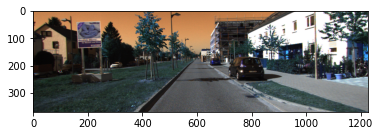

In [2]:
settings = st.Settings()
data_path = './dataset/2011_09_30/'
velo_path = data_path + '/sequences/velodyne'
fr = 0
image_path = data_path + '/color/image_02'
poses_path = data_path + '/poses/data'

# print frame 89 camera image
camera = Kitti(frame=fr,camera_path=image_path)
image = camera.camera_file

plt.imshow(image)
print(image.shape)

In [3]:
def print_projection_cv2(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),2, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

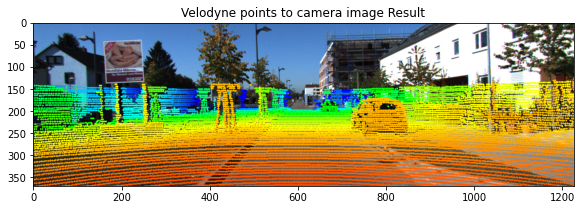

In [4]:
""" save one frame about projecting velodyne points into camera image """
v_fov, h_fov = (-24.9, 20.0), (-90, 90)

v2c_filepath = data_path + '/calibration/calib_velo_to_cam.txt'
c2c_filepath = data_path + '/calibration/calib_cam_to_cam.txt'

res = Kitti_util(frame=fr, camera_path=image_path, velo_path=velo_path, poses_path=poses_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

img, pnt, c_  = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

result = print_projection_plt(pnt, c_, img)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Velodyne points to camera image Result")
plt.imshow(result)

In [5]:
poses_path = data_path + '/poses/poses.txt'
poses = np.loadtxt(poses_path)
c2v = np.asarray([[0, 0, 1],[-1, 0, 0],[0, -1, 0]])
# print(c2v)
T = poses[0].reshape(3,4)
R = c2v.dot(T[0:3,0:3].dot(c2v.T))
t = c2v.dot(T[0:3,3])
print(R)
print(t)
# print(c2v.dot(R.dot(c2v.T)))
# print(c2v@R@c2v.T)
# ix = np.linspace(0, 300-1, 300)
# iy = np.linspace(0, 120-1, 120)
# imx, imy = np.meshgrid(range(300), range(120), indexing='ij')
# imx = imx.reshape(300*120,)
# imy = imy.reshape(300*120,)
# print(imx.shape)
# print(imy.shape)

# a = np.asarray([imx[:], imy[:]])
# print(a)

[[ 1.000000e+00 -1.704638e-10 -3.562503e-10]
 [-1.704638e-10  1.000000e+00  1.197625e-11]
 [-3.562503e-10  1.197625e-11  1.000000e+00]]
[2.220446e-16 0.000000e+00 1.110223e-16]


In [6]:
history = []
for f in range(2):
    res = Kitti_util(frame=fr+f, camera_path=image_path, velo_path=velo_path, poses_path=poses_path,  \
                    v2c_path=v2c_filepath, c2c_path=c2c_filepath)
    T = poses[fr+f].reshape(3,4)
    
    R = c2v.dot(T[0:3,0:3].dot(c2v.T))
    t = c2v.dot(T[0:3,3])
#     R = c2v.dot(T[0:3,0:3].dot(c2v.T))
#     t = c2v.dot(T[0:3,3])
    x_range, y_range, z_range, scale = (-20, 40), (-12, 12), (-2, 1), 10
    pnt_velo, c = res.velo_points(x_range=x_range, y_range=y_range, z_range=z_range)
    
    pnt_velo[2,:] = pnt_velo[2,:] + 1.73 # Add floor bias
    

#     for i in range(100):
#         print( pnt_velo[:,i])
    # Get rotation and translation from GPS/IMU for the current frame
#     R, t = util.pose_from_oxts_packet(res.poses_file)

    print(pnt_velo.shape)
    grid = gr.Grid(settings, R, t)
    
    print(grid.grid.shape)
    grid.build_height_grid(pnt_velo)
    
    history.append(grid)

(4, 86255)
(300, 120)
(4, 86804)
(300, 120)


<AxesSubplot:>

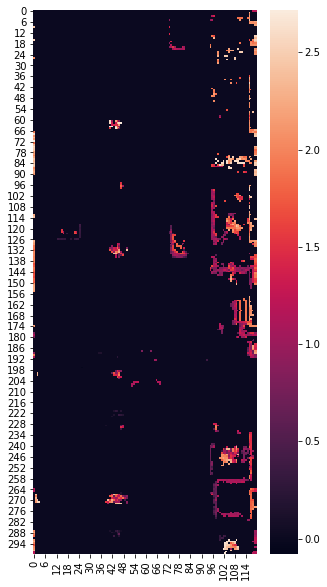

In [7]:
# grid.grid = np.multiply(grid.object_grid, grid.grid_avg)
sns.color_palette("flare", as_cmap=True)
fig, ax2 = plt.subplots(1,1,figsize= (5,10))
# ax2.invert_xaxis()
# ax2.invert_yaxis()
# ax.set_xlim(settings.cell_size_x, 0)  # decreasing time
# ax.set_ylim(0,settings.cell_size_y)  # decreasing time
sns.heatmap(ax=ax2, data=history[0].grid)
# plt.subplots(1,1, figsize = (10,10))
# plt.imshow(grid.grid)

# plt.subplots(1,1, figsize = (10,10))
# plt.imshow(history[0].object_grid)

In [8]:


print(history[0].t)
print(history[0].R)
print(history[0].grid_points.shape)
rotated_points = history[0].R.dot(history[0].grid_points[:,:])
# rotated_points
for i in range(10):
    print("0",history[0].grid_points[:,i])
    print("1",rotated_points[:,i])
    print("2",history[0].grid_points_transformed[:,i])
    

[2.220446e-16 0.000000e+00 1.110223e-16]
[[ 1.000000e+00 -1.704638e-10 -3.562503e-10]
 [-1.704638e-10  1.000000e+00  1.197625e-11]
 [-3.562503e-10  1.197625e-11  1.000000e+00]]
(3, 36000)
0 [-20. -12.   0.]
1 [-2.000000e+01 -1.200000e+01  6.981291e-09]
2 [-2.00000000e+01 -1.20000000e+01  6.98129111e-09]
0 [-20.  -11.8   0. ]
1 [-2.00000000e+01 -1.18000000e+01  6.98368625e-09]
2 [-2.00000000e+01 -1.18000000e+01  6.98368636e-09]
0 [-20.  -11.6   0. ]
1 [-2.0000000e+01 -1.1600000e+01  6.9860815e-09]
2 [-2.00000000e+01 -1.16000000e+01  6.98608161e-09]
0 [-20.  -11.4   0. ]
1 [-2.00000000e+01 -1.14000000e+01  6.98847675e-09]
2 [-2.00000000e+01 -1.14000000e+01  6.98847686e-09]
0 [-20.  -11.2   0. ]
1 [-2.000000e+01 -1.120000e+01  6.990872e-09]
2 [-2.00000000e+01 -1.12000000e+01  6.99087211e-09]
0 [-20. -11.   0.]
1 [-2.00000000e+01 -1.10000000e+01  6.99326725e-09]
2 [-2.00000000e+01 -1.10000000e+01  6.99326736e-09]
0 [-20.  -10.8   0. ]
1 [-2.0000000e+01 -1.0800000e+01  6.9956625e-09]
2 [-2.

In [9]:
np.tile([-grid.settings.grid_xb/grid.settings.cell_size_x, -grid.settings.grid_yr/grid.settings.cell_size_y],[36000,1]).T
print(-grid.settings.grid_xb/grid.settings.cell_size_x)

100.0


In [10]:

print(history[0].grid_points_transformed[:,0])

[-2.00000000e+01 -1.20000000e+01  6.98129111e-09]


[0.         0.         0.         ... 0.         1.17828571 1.17216666]
(3, 36000)
4 [-7.  0.  0.]
4 [-7.  1.  0.]
4 [-7.  2.  0.]
4 [-7.  3.  0.]
4 [-7.  4.  0.]
4 [-7.  5.  0.]
4 [-7.  6.  0.]
4 [-7.  7.  0.]
4 [-7.  8.  0.]
4 [-7.  9.  0.]
4 [-7. 10.  0.]
4 [-7. 11.  0.]
4 [-7. 12.  0.]
4 [-7. 13.  0.]
4 [-7. 14.  0.]
4 [-7. 15.  0.]
4 [-7. 16.  0.]
4 [-7. 17.  0.]
4 [-7. 18.  0.]
4 [-7. 19.  0.]
4 [-7. 20.  0.]
4 [-7. 21.  0.]
4 [-7. 22.  0.]
4 [-7. 23.  0.]
4 [-7. 24.  0.]
4 [-7. 25.  0.]
4 [-7. 26.  0.]
4 [-7. 27.  0.]
4 [-7. 28.  0.]
4 [-7. 29.  0.]
4 [-7. 30.  0.]
4 [-7. 31.  0.]
4 [-7. 32.  0.]
4 [-7. 33.  0.]
4 [-7. 34.  0.]
4 [-7. 35.  0.]
4 [-7. 36.  0.]
4 [-7. 37.  0.]
4 [-7. 38.  0.]
4 [-7. 39.  0.]
4 [-7. 40.  0.]
4 [-7. 41.  0.]
4 [-7. 42.  0.]
4 [-7. 43.  0.]
4 [-7. 44.  0.]
4 [-7. 45. -0.]
4 [-7. 46. -0.]
4 [-7. 47.  0.]
4 [-7. 48.  0.]
4 [-7. 49.  0.]
4 [-7. 50. -0.]
4 [-7. 51.  0.]
4 [-7. 52.  0.]
4 [-6. 53.  0.]
4 [-6. 54.  0.]
4 [-6. 55.  0.]
4 [-6. 56.  0.]
4 [-6

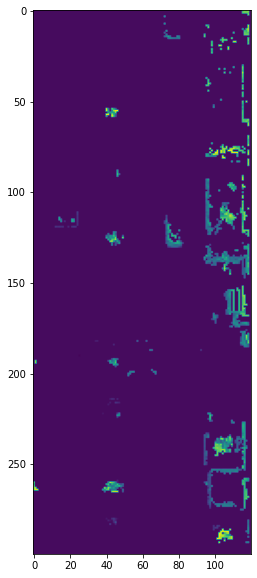

In [13]:
untrasformed_points = np.zeros(history[0].grid_points.shape)
# trasformed_points = np.zeros(history[0].grid_points.shape)

R = history[1].R
t = history[1].t
# print(history[0].grid_points_transformed)
# untrasformed_points = history[0].grid_points_transformed
# untrasformed_points = np.asarray([history[0].grid_points_transformed[0,:] - t[0], \
#                                   history[0].grid_points_transformed[1,:] - t[1], \
#                                   history[0].grid_points_transformed[2,:] - t[2],])
untrasformed_points = np.subtract(history[0].grid_points_transformed.T, t)
untrasformed_points = R.T.dot(untrasformed_points.T)
imz = history[0].grid.reshape(history[0].grid_size[0]*history[0].grid_size[1],)
print(imz)
# untrasformed_points = untrasformed_points.T
untrasformed_points[2,:] = imz[:]



idx_quantizized = np.floor([untrasformed_points[0,:]/grid.settings.cell_size_x, untrasformed_points[1,:]/grid.settings.cell_size_y])
idx_quantizized_trans = [idx_quantizized[0,:] - grid.settings.grid_xb/grid.settings.cell_size_x, \
                         idx_quantizized[1,:] - grid.settings.grid_yr/grid.settings.cell_size_y]


untrasformed_points[0:2,:] = np.divide(untrasformed_points[0:2,:],np.tile([grid.settings.cell_size_x,grid.settings.cell_size_y],[36000,1]).T)
untrasformed_points[0:2,:] =  np.floor(np.add(untrasformed_points[0:2,:],np.tile([-grid.settings.grid_xb/grid.settings.cell_size_x, -grid.settings.grid_yr/grid.settings.cell_size_y],[36000,1]).T))
print(untrasformed_points.shape)
for i in range(1000):
#     print("0",history[0].grid_points[:,i])
#     print("1",history[0].grid_points_transformed[:,i])
#     print("2",idx_quantizized_trans[0][i], idx_quantizized_trans[1][i])
#     print("3",trasformed_points[:,i])
    print("4",untrasformed_points[:,i])

valid_idx = np.logical_and(np.logical_and(untrasformed_points[0,:] >= 0 ,untrasformed_points[0,:] <= ((grid.settings.grid_xf - grid.settings.grid_xb) / grid.settings.cell_size_x - 1)), \
                           np.logical_and(untrasformed_points[1,:] >= 0 ,untrasformed_points[1,:] <= ((grid.settings.grid_yl - grid.settings.grid_yr) / grid.settings.cell_size_y - 1)) )

print(valid_idx, valid_idx.shape)
# valid_idx = np.logical_not(valid_idx)
valid_points = untrasformed_points[:,valid_idx]
print(valid_points, valid_points.shape)
transformed_grid =  np.zeros(grid.grid_size)
print(transformed_grid.shape)
for i in range(valid_points.shape[1]):
#     print("0",idx_quantizized_trans[0][i],idx_quantizized_trans[1][i])
    
    x = int(valid_points[0,i])
    y = int(valid_points[1,i])
    z = valid_points[2,i]
#     print("1",x,y,z)
#     if z != 0.:
#         print("1",x,y,z)
    transformed_grid[x, y] = z

plt.subplots(1,1, figsize = (10,10))
plt.imshow(transformed_grid)